In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.utils.vis_utils import plot_model

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def data_preparation(raw_data, labels=False, img_height=28, img_width=28, num_classes=10):
    
    data_X = raw_data.loc[:,"pixel0":].to_numpy()
    X = np.reshape(data_X, (len(raw_data.index), img_height, img_width, 1))
    X = X.astype('float32')
    X = X / 255.0
    
    y = None
    if labels:
        y = keras.utils.to_categorical(train["label"], num_classes)
    
    return X, y

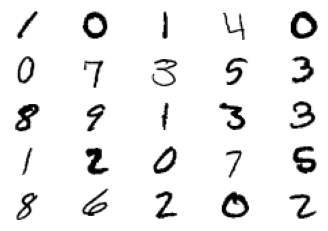

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

X, _ = data_preparation(train, labels=False)

for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(np.squeeze(X[i], axis=-1) * 255.0, cmap='gray_r')
plt.show()

In [6]:
def simple_classificator(img_height=28, img_width=28, num_classes=10):
    model = Sequential()
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same', input_shape=(img_height,img_width,1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = simple_classificator()
plot_model(model, to_file='classificator_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       3328      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [7]:
def generate_data_samples(raw_data, n_samples):
    X, y = data_preparation(raw_data, labels=True)
    ix = np.random.randint(0, X.shape[0], n_samples)
    sample_X = X[ix]
    sample_y = y[ix]
    return sample_X, sample_y

In [8]:
def model_performance(epoch, model, raw_data, n_samples=100):
    X, y = generate_data_samples(raw_data, n_samples)
    _, acc = model.evaluate(X, y, verbose=0)
    print(f'>Accuracy: {format(acc*100, ".3f")}')

In [9]:
import time
def train_model(model, raw_data, n_epochs=100, n_batch=250):
    bat_per_epo = int(raw_data.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        start = time.time()
        for j in range(bat_per_epo):
            X, y = generate_data_samples(raw_data, half_batch)
            loss, _ = model.train_on_batch(X, y)
            if (j + 1) % 168 == 0:
                print(f'>Epoch {i+1}, batch {j+1} / {bat_per_epo}, loss: {format(loss, ".3f")}, {format(time.time() - start, ".3f")} sec.')
        if (i+1) % 10 == 0:
            model_performance(i, model, raw_data)

In [10]:
train_model(model, train, n_epochs=100)

>Epoch 1, batch 168 / 168, loss: 0.398, 24.398 sec.
>Epoch 2, batch 168 / 168, loss: 0.292, 20.494 sec.
>Epoch 3, batch 168 / 168, loss: 0.325, 19.850 sec.
>Epoch 4, batch 168 / 168, loss: 0.288, 20.117 sec.
>Epoch 5, batch 168 / 168, loss: 0.161, 20.302 sec.
>Epoch 6, batch 168 / 168, loss: 0.087, 20.090 sec.
>Epoch 7, batch 168 / 168, loss: 0.232, 19.957 sec.
>Epoch 8, batch 168 / 168, loss: 0.088, 20.609 sec.
>Epoch 9, batch 168 / 168, loss: 0.129, 20.014 sec.
>Epoch 10, batch 168 / 168, loss: 0.101, 19.743 sec.
>Accuracy: 99.000
>Epoch 11, batch 168 / 168, loss: 0.027, 20.770 sec.
>Epoch 12, batch 168 / 168, loss: 0.076, 19.972 sec.
>Epoch 13, batch 168 / 168, loss: 0.071, 19.860 sec.
>Epoch 14, batch 168 / 168, loss: 0.047, 20.682 sec.
>Epoch 15, batch 168 / 168, loss: 0.097, 19.987 sec.
>Epoch 16, batch 168 / 168, loss: 0.044, 19.641 sec.
>Epoch 17, batch 168 / 168, loss: 0.148, 20.662 sec.
>Epoch 18, batch 168 / 168, loss: 0.067, 20.236 sec.
>Epoch 19, batch 168 / 168, loss: 0.0

In [11]:
test_X, _ = data_preparation(test)
predictions = model.predict(test_X)
labels = predictions.argmax(axis=-1)
labels

array([2, 0, 9, ..., 3, 9, 2])

In [12]:
pd.DataFrame(data={"ImageId":range(1, len(labels) + 1), "Label":labels}).to_csv("submission.csv", index=False)